In [3]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 10})

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

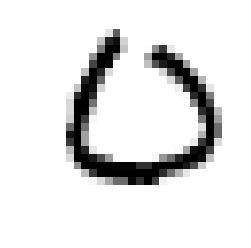

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[3500]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
          interpolation='nearest')
plt.axis('off')
plt.show()

In [7]:
y[3500]

0.0

In [8]:
train_set_size = 60000
X_train, X_test, y_train, y_test = X[:train_set_size], X[train_set_size:], y[:train_set_size], y[train_set_size:]

In [9]:
import numpy as np

shuffle_index = np.random.permutation(train_set_size)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

In [10]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [11]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([False])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9653069386122776
0.9643482174108705
0.9593939090863629


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9647 , 0.93025, 0.9635 ])

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91   , 0.90705, 0.9119 ])

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53031,  1548],
       [ 1283,  4138]])

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7277523742525501

In [20]:
recall_score(y_train_5, y_train_pred)

0.7633277992990223

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7451156928063383

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores 

array([-422915.49146583])

In [23]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

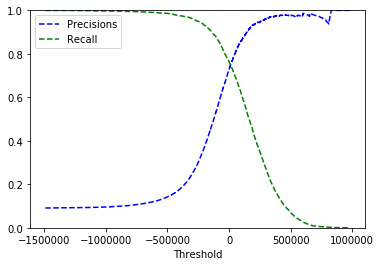

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precisions')   
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
y_train_pred_90 = (y_scores > 70000)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.8300367985280589

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.6657443276148313

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

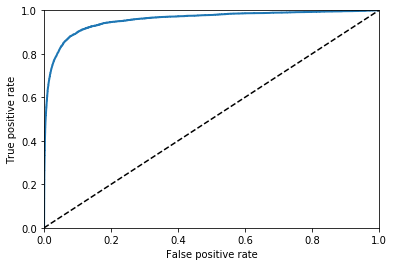

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9567133890822305

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probabs_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                    cv=3, method='predict_proba')
y_scores_forest = y_probabs_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9938173507213619

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([0.])

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores 

array([[  205542.76435339, -1025188.66948216,  -226186.50475793,
         -372219.67561098,  -732343.1316112 ,  -422915.49146583,
         -345751.16367504,  -836047.07116828,  -262406.23394333,
         -943440.36392399]])

In [37]:
np.argmax(some_digit_scores)

0

In [38]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [39]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([0.])

In [40]:
len(ovo_clf.estimators_)

45

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.86152769, 0.79923996, 0.87053058])

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, 
                cv=3, scoring='accuracy')

array([0.91111778, 0.90679534, 0.90993649])

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, 
                                y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx 

array([[5729,    2,   23,   11,   10,   48,   48,   11,   36,    5],
       [   2, 6500,   47,   26,    6,   38,    6,   10,   95,   12],
       [  49,   39, 5325,  114,   82,   23,   94,   53,  163,   16],
       [  46,   46,  138, 5344,    4,  235,   37,   51,  133,   97],
       [  19,   28,   39,    8, 5357,   11,   57,   33,   81,  209],
       [  73,   46,   32,  178,   83, 4595,  118,   28,  166,  102],
       [  32,   24,   49,    2,   35,   90, 5635,    8,   42,    1],
       [  21,   26,   70,   31,   47,   12,    6, 5826,   14,  212],
       [  54,  167,   76,  168,   13,  157,   58,   26, 4978,  154],
       [  41,   34,   28,   93,  164,   36,    3,  213,   69, 5268]])

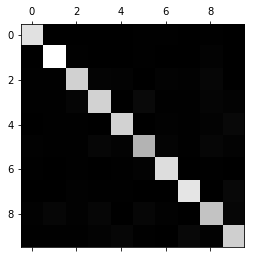

In [44]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

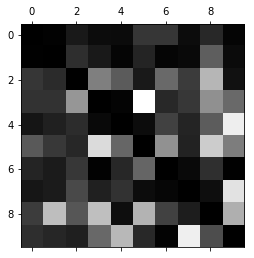

In [45]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

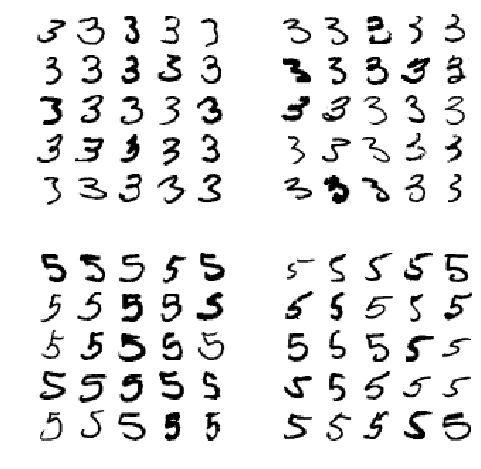

In [46]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [47]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [48]:
knn_clf.predict([some_digit])

array([[False, False]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, 
                                     cv=3, verbose=10)
f1_score(y_train, y_train_knn_pred, average='macro')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
